In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, f1_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


# Merge and Encode

In [2]:
basics_df = pd.read_csv('./title.basics.tsv.gz', delimiter="\t")
basics_movies_df =  basics_df[basics_df.titleType=="movie"]
ratings_df = pd.read_csv('./title.ratings.tsv.gz', delimiter="\t")

basics_ratings_movie_df = basics_movies_df.merge(ratings_df,
                                                 on='tconst', how='left')
basics_ratings_movie_df=basics_ratings_movie_df.drop(columns=["endYear",
                                                              "titleType",
                                                              "tconst",
                                                              "originalTitle"])
basics_ratings_movie_df.replace(["\\N"],np.nan,inplace=True)
basics_ratings_movie_df=basics_ratings_movie_df.dropna()
basics_ratings_movie_df["startYear"] = pd.to_numeric(basics_ratings_movie_df["startYear"])
basics_ratings_movie_df["runtimeMinutes"] = pd.to_numeric(basics_ratings_movie_df["runtimeMinutes"])
basics_ratings_movie_df["isAdult"] = pd.to_numeric(basics_ratings_movie_df["isAdult"])
basics_ratings_movie_df

/var/folders/b5/x127tcr10t39rfngm9vkr2640000gn/T/ipykernel_30510/2086658022.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  basics_df = pd.read_csv('./title.basics.tsv.gz', delimiter="\t")


,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
0,Miss Jerry,0,1894,45,Romance,5.3,207.0
1,The Corbett-Fitzsimmons Fight,0,1897,100,"Documentary,News,Sport",5.3,483.0
3,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography",6.0,854.0
4,The Prodigal Son,0,1907,90,Drama,5.0,21.0
8,The Fairylogue and Radio-Plays,0,1908,120,"Adventure,Fantasy",5.1,68.0
...,...,...,...,...,...,...,...
661804,Safeguard,0,2020,95,"Action,Adventure,Thriller",3.7,245.0
661805,Il talento del calabrone,0,2020,84,Thriller,5.8,1446.0
661806,Coven,0,2020,92,"Drama,History",6.4,5591.0
661808,Kuambil Lagi Hatiku,0,2019,123,Drama,8.6,7.0


# Explore Distributions

## Scatterplots for numerical features

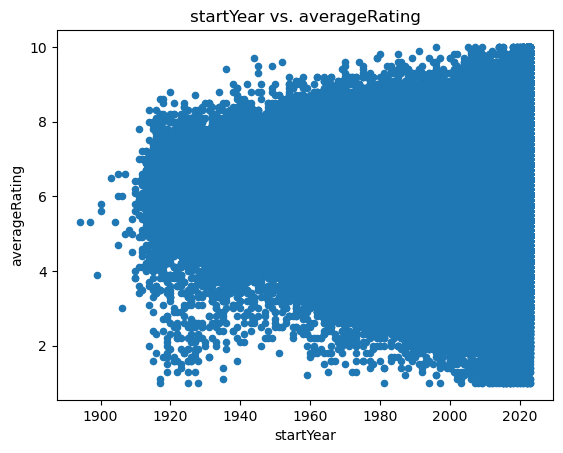

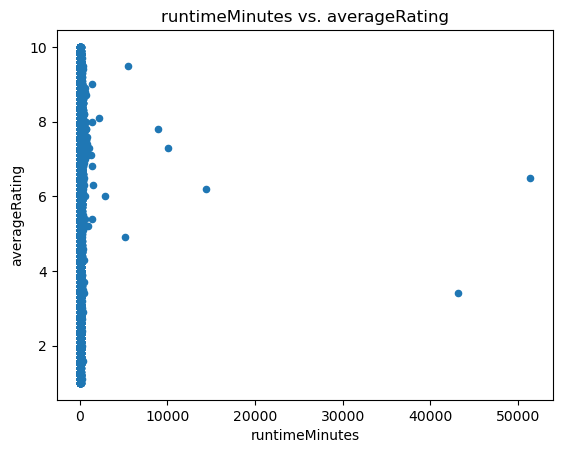

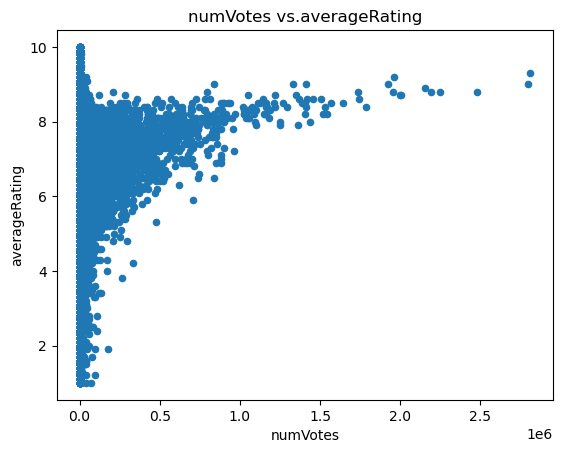

In [3]:
startYear_df = basics_ratings_movie_df[["startYear", "averageRating"]]
startYear_df.plot.scatter(x="startYear", y="averageRating", xlabel="startYear",
                          ylabel="averageRating",
                          title="startYear vs. averageRating")
plt.show()

runtimeMinutes_df = basics_ratings_movie_df[["runtimeMinutes", "averageRating"]]
runtimeMinutes_df.plot.scatter(x="runtimeMinutes", y="averageRating",
                               xlabel="runtimeMinutes",
                               ylabel="averageRating",
                               title="runtimeMinutes vs. averageRating")
plt.show()

numVotes_df = basics_ratings_movie_df[["numVotes", "averageRating"]]
numVotes_df.plot.scatter(x="numVotes", y="averageRating",
                         xlabel="numVotes",
                         ylabel="averageRating",
                         title="numVotes vs.averageRating")
plt.show()


## Bar plots for categorical features

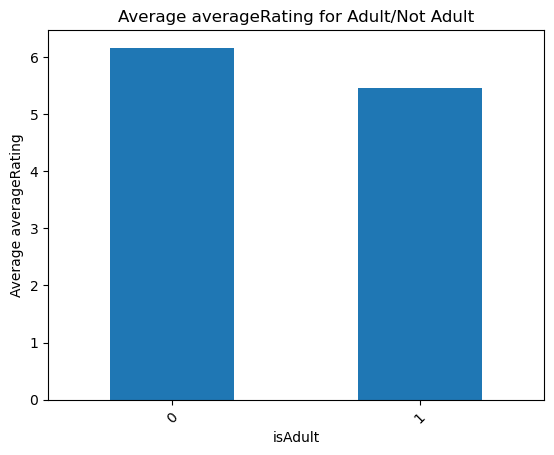

In [4]:
isAdult_df = basics_ratings_movie_df[["isAdult", "averageRating"]].groupby("isAdult").mean()
isAdult_df.plot.bar(rot=45, legend=False, ylabel="Average averageRating",
                    title="Average averageRating for Adult/Not Adult")
plt.show()

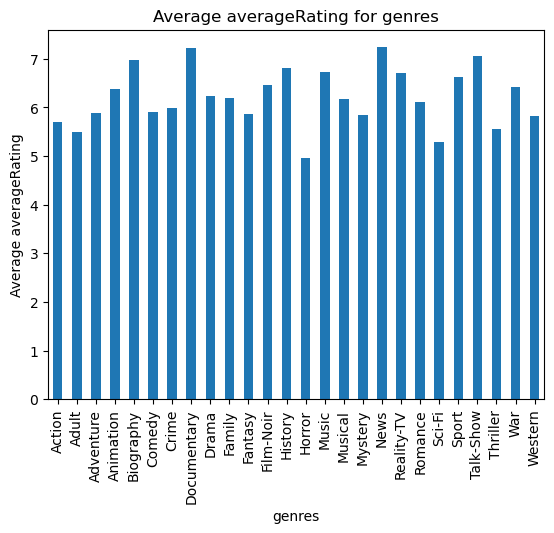

In [5]:
# Split (explode) pandas dataframe string entry to separate rows
listed_genre_df = basics_ratings_movie_df.assign(**{"genres":basics_ratings_movie_df["genres"].str.split(',')})
populated_df = listed_genre_df.explode("genres")
genre_df = populated_df[["genres", "averageRating"]].groupby("genres").mean()
genre_df.plot.bar(legend=False, ylabel="Average averageRating",
                  title="Average averageRating for genres")
plt.show()

## Correlation Matrix

# Baseline Models (allow multiple genre in each observation)

In [6]:
basics_ratings_movie_oh = pd.concat([basics_ratings_movie_df.drop(columns="genres"),
                                     basics_ratings_movie_df["genres"].str.get_dummies(sep=",")],
                                     axis=1)
X = basics_ratings_movie_oh.drop(columns=["averageRating", "primaryTitle"])
y = basics_ratings_movie_oh["averageRating"]
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=42,
                                                test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev,
                                                  random_state=42, test_size=0.25)

# Standardize?

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)
train_predict = lr.predict(X_train)
val_predict = lr.predict(X_val)
test_predict = lr.predict(X_test)
train_r2 = r2_score(y_train, train_predict)
val_r2 = r2_score(y_val, val_predict)
test_r2 = r2_score(y_test, test_predict)
print("R2 for training data",train_r2)
print("R2 for validation data",val_r2)
print("R2 for Test data",test_r2)

R2 for training data 0.2183686759786979
R2 for validation data 0.21674254097494572
R2 for Test data 0.22273221931013065


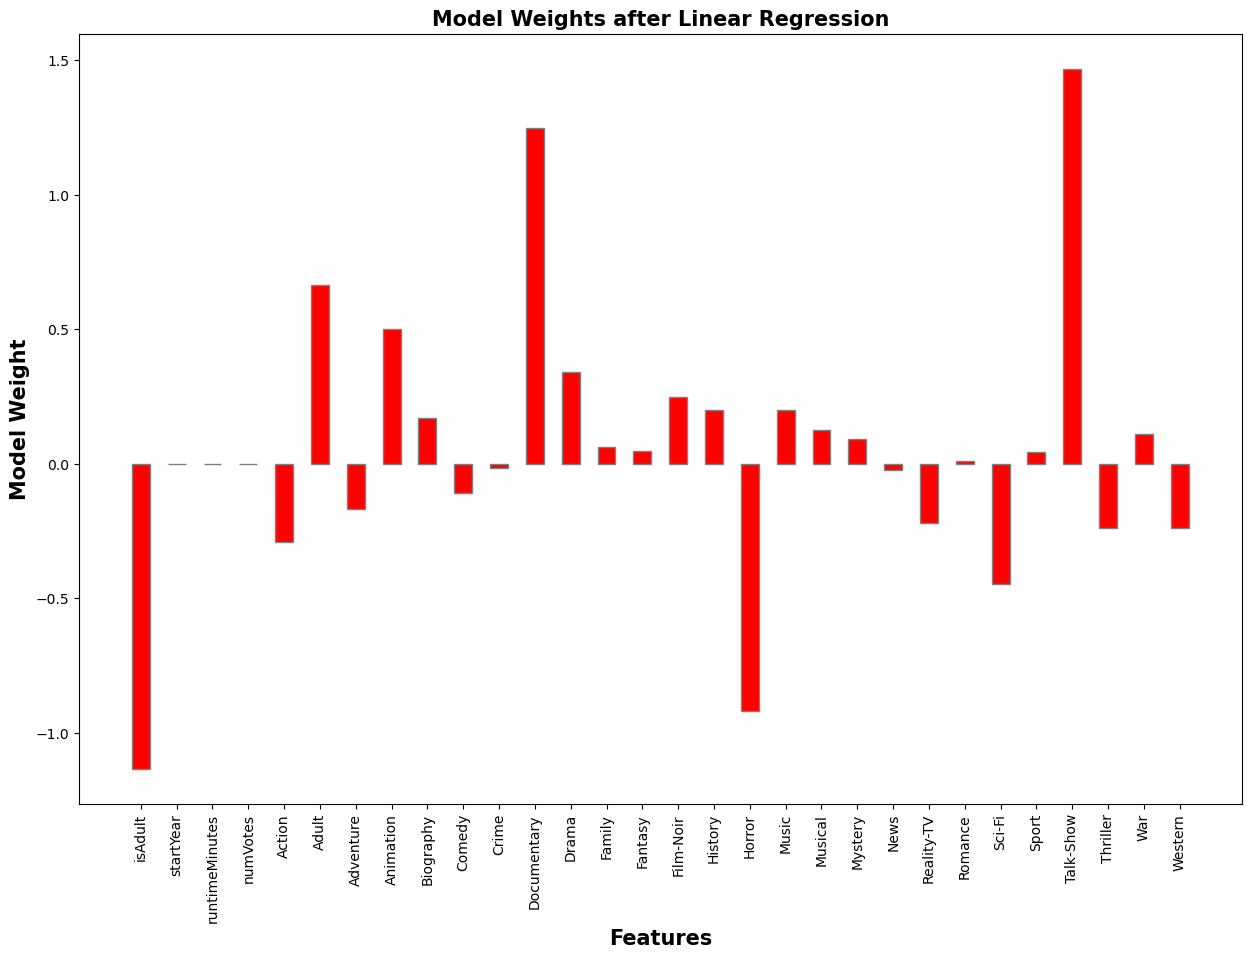

In [8]:
barWidth = 0.50
fig = plt.subplots(figsize =(15, 10))
plt.bar(list(X_dev.columns), lr.coef_, color ='r', width = barWidth,
        edgecolor ='grey', label ='Weight')
plt.title('Model Weights after Linear Regression', fontweight ='bold', fontsize = 15)
plt.xlabel('Features', fontweight ='bold', fontsize = 15, wrap = True)
plt.ylabel('Model Weight', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(X.columns))],
           list(X_dev.columns), rotation ='vertical')
plt.show()

In [9]:
dr = DecisionTreeRegressor()
dr.fit(X_dev, y_dev)
dr_y_predict = dr.predict(X_test)
mean_squared_error(y_test,dr_y_predict)

2.4310103065821185

In [10]:
xgb = XGBRegressor()
xgb.fit(X_dev, y_dev)
xgb_y_predict = xgb.predict(X_test)
mean_squared_error(y_test,xgb_y_predict)

1.1852206470462219

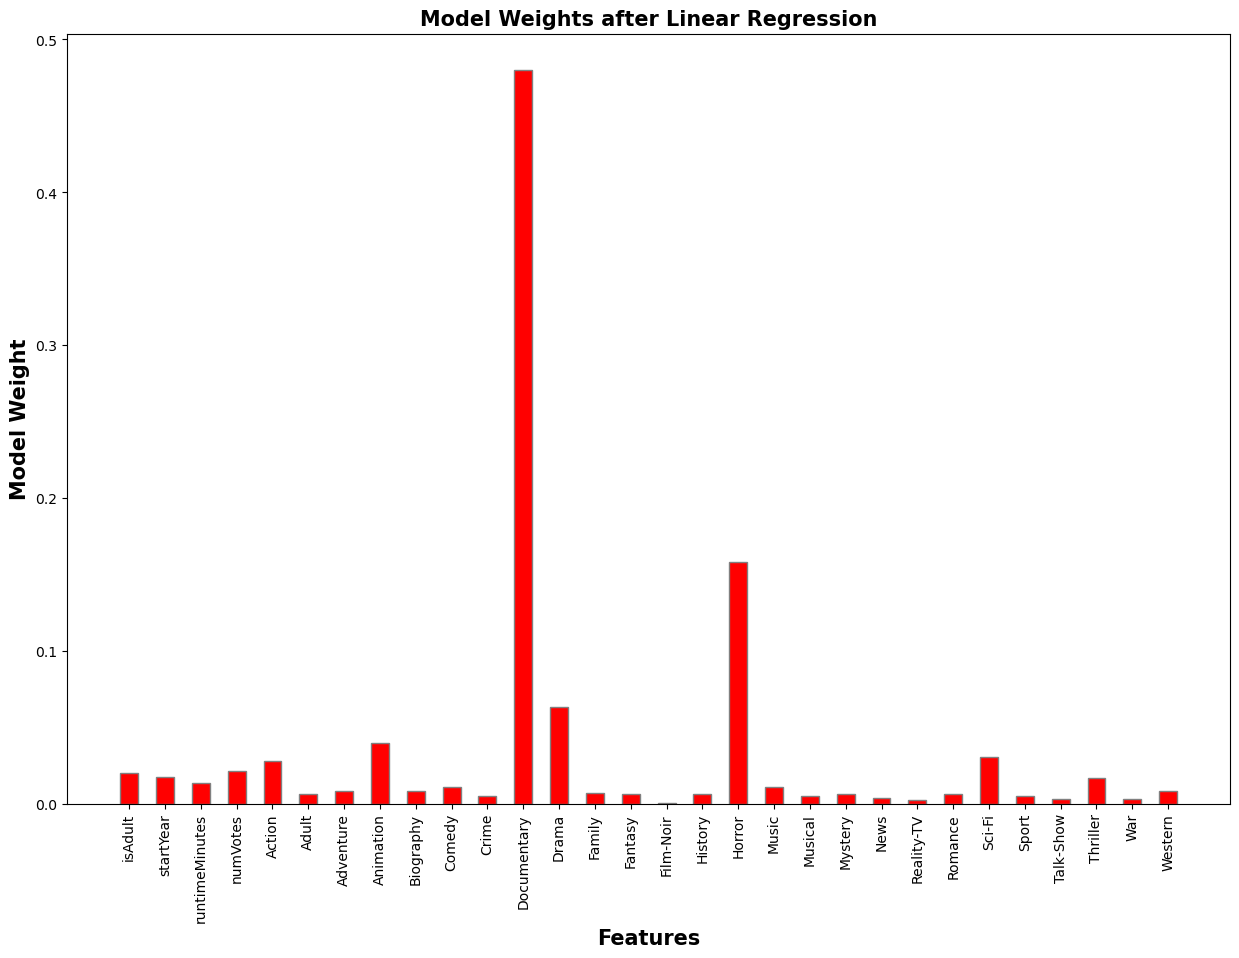

In [11]:
barWidth = 0.50
fig = plt.subplots(figsize =(15, 10))
plt.bar(list(X_dev.columns), xgb.feature_importances_, color ='r', width = barWidth,
        edgecolor ='grey', label ='Weight')
plt.title('Model Weights after Linear Regression', fontweight ='bold', fontsize = 15)
plt.xlabel('Features', fontweight ='bold', fontsize = 15, wrap = True)
plt.ylabel('Model Weight', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(X_dev.columns))],
           list(X.columns), rotation ='vertical')
plt.show()

In [12]:
feature_names = X_dev.columns
feature_imps = zip(feature_names, xgb.feature_importances_)
feature_imps=sorted(list(feature_imps), key=lambda x: x[1], reverse=True)
feature_imps

[('Documentary', 0.47985566),
 ('Horror', 0.15803087),
 ('Drama', 0.06346324),
 ('Animation', 0.039336387),
 ('Sci-Fi', 0.030715052),
 ('Action', 0.028116351),
 ('numVotes', 0.0210581),
 ('isAdult', 0.020341674),
 ('startYear', 0.017491657),
 ('Thriller', 0.016705904),
 ('runtimeMinutes', 0.013646598),
 ('Music', 0.01112605),
 ('Comedy', 0.010958748),
 ('Biography', 0.008448083),
 ('Adventure', 0.008290255),
 ('Western', 0.008012838),
 ('Family', 0.007079489),
 ('History', 0.0064955954),
 ('Adult', 0.006442),
 ('Romance', 0.006088131),
 ('Mystery', 0.0060145357),
 ('Fantasy', 0.0060128253),
 ('Musical', 0.0047478373),
 ('Crime', 0.0047168154),
 ('Sport', 0.00466264),
 ('News', 0.003731662),
 ('Talk-Show', 0.002780845),
 ('War', 0.0027805981),
 ('Reality-TV', 0.002435163),
 ('Film-Noir', 0.00041435205)]

In [13]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_dev, y_dev)
rf_y_predict = rf.predict(X_test)
mean_squared_error(y_test,rf_y_predict)

1.323568342590316

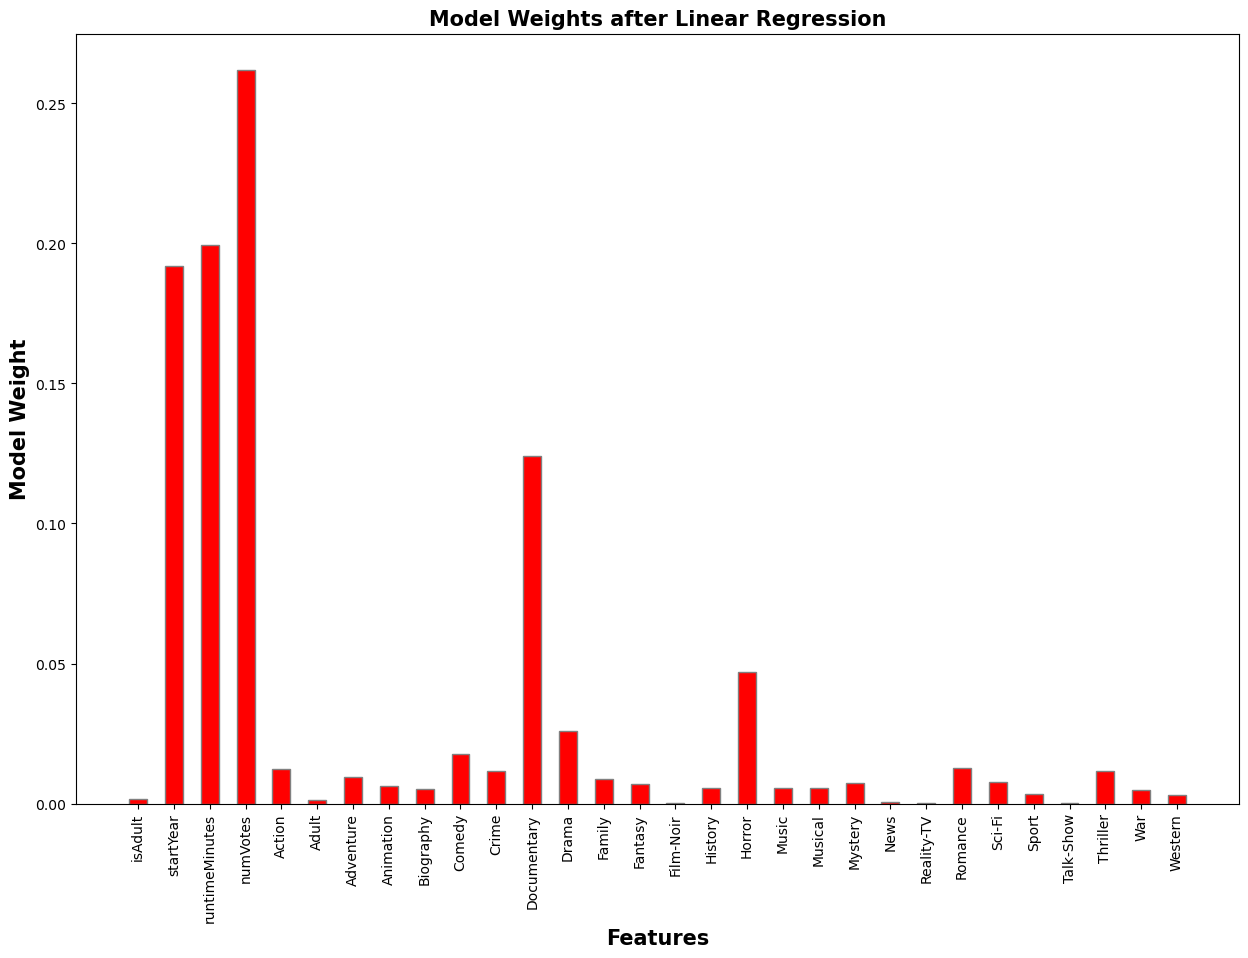

In [14]:
barWidth = 0.50
fig = plt.subplots(figsize =(15, 10))
plt.bar(list(X_dev.columns), rf.feature_importances_, color ='r', width = barWidth,
        edgecolor ='grey', label ='Weight')
plt.title('Model Weights after Linear Regression', fontweight ='bold', fontsize = 15)
plt.xlabel('Features', fontweight ='bold', fontsize = 15, wrap = True)
plt.ylabel('Model Weight', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(X_dev.columns))],
           list(X.columns), rotation ='vertical')
plt.show()

In [15]:
feature_names = X_dev.columns
feature_imps = zip(feature_names, rf.feature_importances_)
feature_imps=sorted(list(feature_imps), key=lambda x: x[1], reverse=True)
feature_imps

[('numVotes', 0.2617910709245753),
 ('runtimeMinutes', 0.1994490481748628),
 ('startYear', 0.1917819500151973),
 ('Documentary', 0.1240165676238767),
 ('Horror', 0.04704198018642995),
 ('Drama', 0.025851039763940355),
 ('Comedy', 0.017824725545247097),
 ('Romance', 0.012836318599787623),
 ('Action', 0.012418325289073459),
 ('Thriller', 0.0117339588729415),
 ('Crime', 0.011621851983851187),
 ('Adventure', 0.00950953670485073),
 ('Family', 0.008790277426860288),
 ('Sci-Fi', 0.0078371636307497),
 ('Mystery', 0.00726282121388122),
 ('Fantasy', 0.00706633248890198),
 ('Animation', 0.006367190511626372),
 ('Music', 0.0056691362440464505),
 ('Musical', 0.005460816094221753),
 ('History', 0.005427788483430162),
 ('Biography', 0.005284901658191203),
 ('War', 0.004820472043515251),
 ('Sport', 0.0033478042322852277),
 ('Western', 0.003005256408458697),
 ('isAdult', 0.0015726654421955497),
 ('Adult', 0.0011414080956561425),
 ('News', 0.0006067607567650995),
 ('Reality-TV', 0.0002903094783857401),


# Baseline Models (one genre per observation)

In [16]:
basics_ratings_movie_oh = pd.get_dummies(populated_df, columns=["genres"], dtype=int)
X = basics_ratings_movie_oh.drop(columns=["averageRating", "primaryTitle"])
y = basics_ratings_movie_oh["averageRating"]
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=42,
                                                test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev,
                                                  random_state=42, test_size=0.25)

# Standardize?

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
train_predict = lr.predict(X_train)
val_predict = lr.predict(X_val)
test_predict = lr.predict(X_test)
train_r2 = r2_score(y_train, train_predict)
val_r2 = r2_score(y_val, val_predict)
test_r2 = r2_score(y_test, test_predict)
print("R2 for training data",train_r2)
print("R2 for validation data",val_r2)
print("R2 for Test data",test_r2)

R2 for training data 0.16459484506949829
R2 for validation data 0.1106632214616422
R2 for Test data 0.08520392275454114


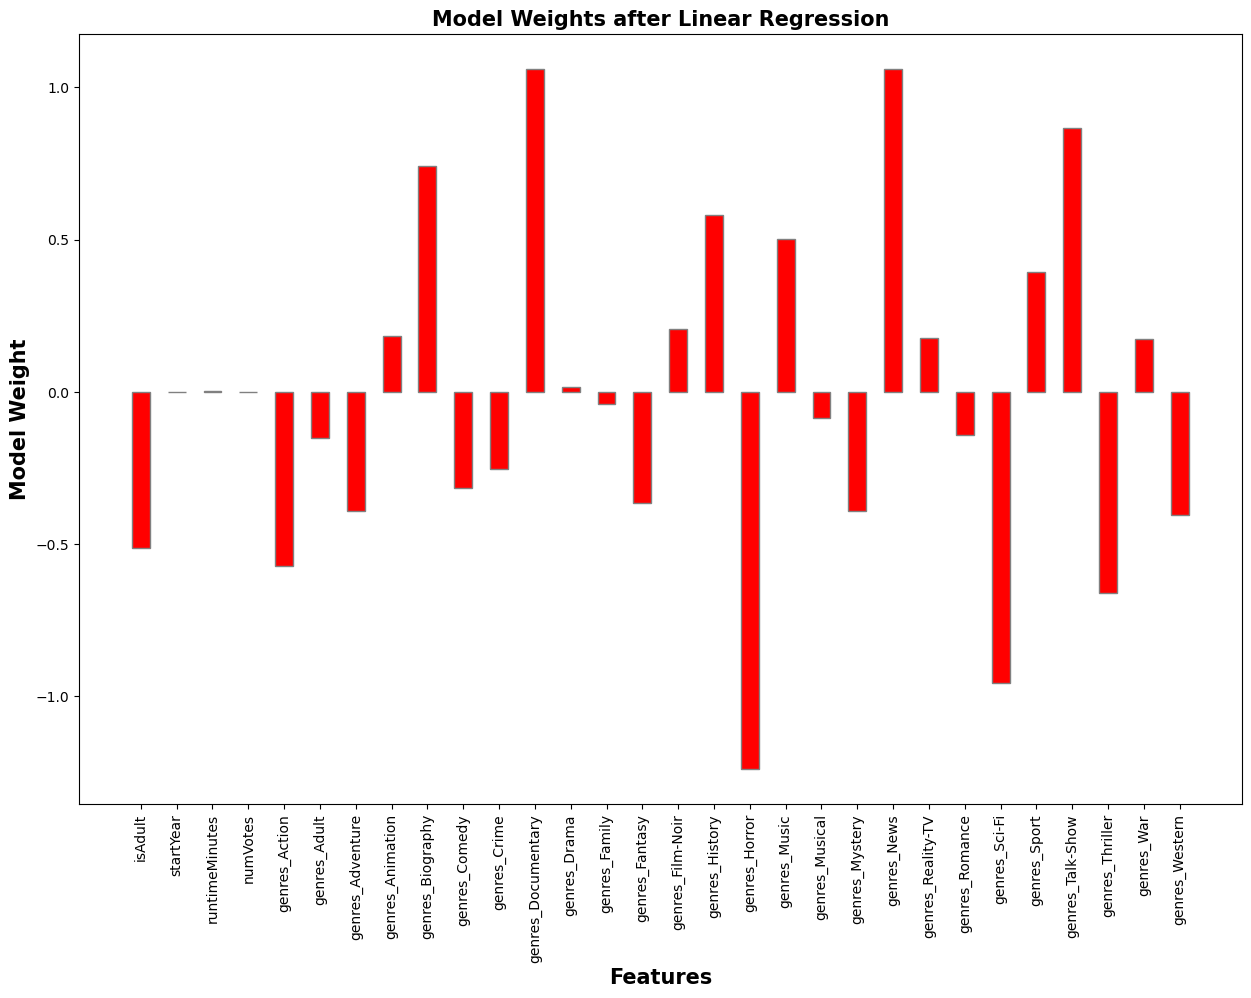

In [18]:
barWidth = 0.50
fig = plt.subplots(figsize =(15, 10))
plt.bar(list(X_dev.columns), lr.coef_, color ='r', width = barWidth,
        edgecolor ='grey', label ='Weight')
plt.title('Model Weights after Linear Regression', fontweight ='bold', fontsize = 15)
plt.xlabel('Features', fontweight ='bold', fontsize = 15, wrap = True)
plt.ylabel('Model Weight', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(X.columns))],
           list(X_dev.columns), rotation ='vertical')
plt.show()

In [19]:
dr = DecisionTreeRegressor()
dr.fit(X_dev, y_dev)
dr_y_predict = dr.predict(X_test)
mean_squared_error(y_test,dr_y_predict)

2.320758246257389

In [20]:
xgb = XGBRegressor()
xgb.fit(X_dev, y_dev)
xgb_y_predict = xgb.predict(X_test)
mean_squared_error(y_test,xgb_y_predict)

1.2112858656050633

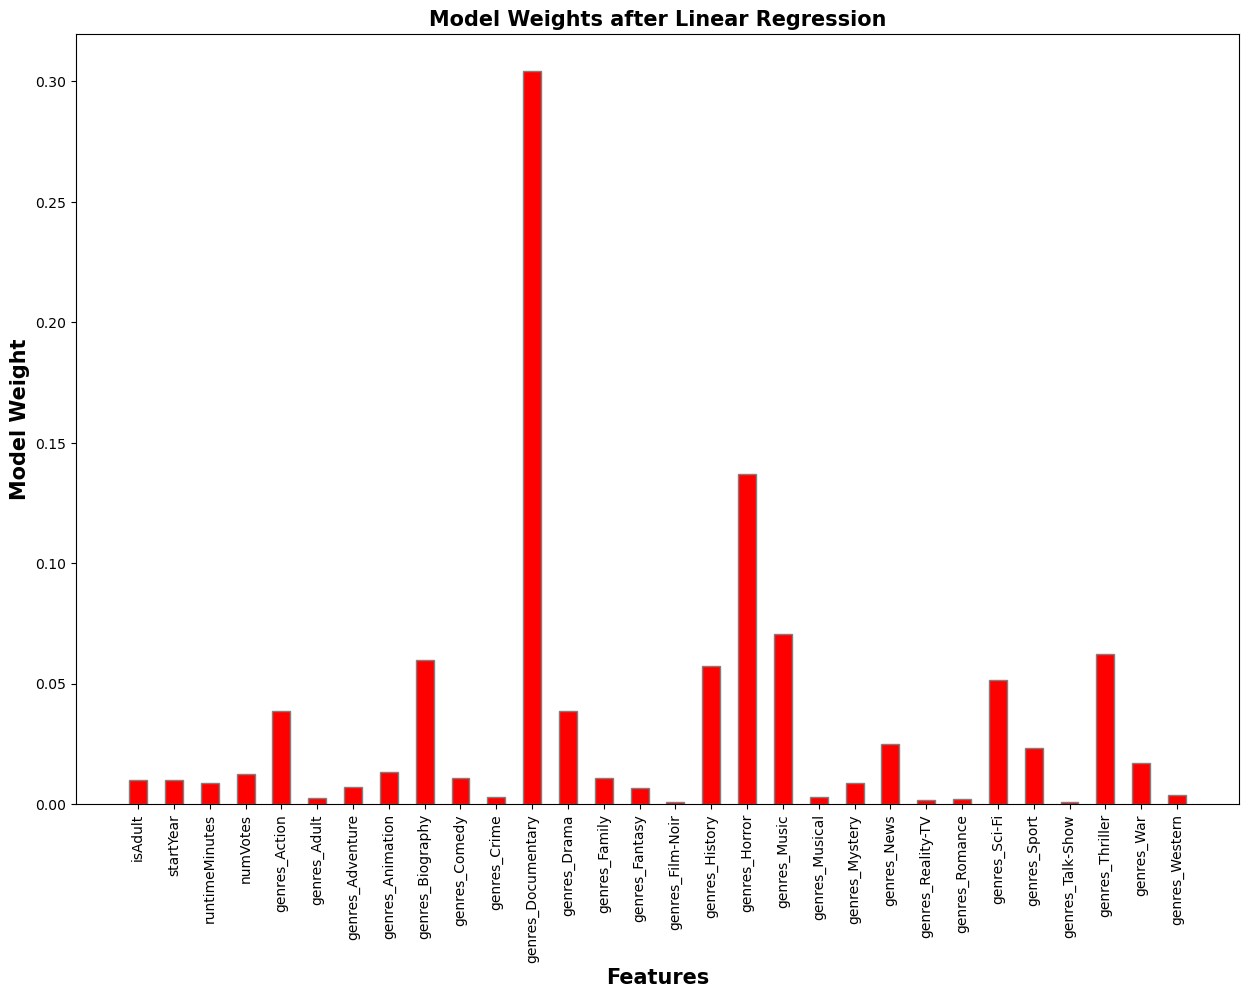

In [21]:
barWidth = 0.50
fig = plt.subplots(figsize =(15, 10))
plt.bar(list(X_dev.columns), xgb.feature_importances_, color ='r', width = barWidth,
        edgecolor ='grey', label ='Weight')
plt.title('Model Weights after Linear Regression', fontweight ='bold', fontsize = 15)
plt.xlabel('Features', fontweight ='bold', fontsize = 15, wrap = True)
plt.ylabel('Model Weight', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(X_dev.columns))],
           list(X.columns), rotation ='vertical')
plt.show()

In [22]:
feature_names = X_dev.columns
feature_imps = zip(feature_names, xgb.feature_importances_)
feature_imps=sorted(list(feature_imps), key=lambda x: x[1], reverse=True)
feature_imps

[('genres_Documentary', 0.3044579),
 ('genres_Horror', 0.1368297),
 ('genres_Music', 0.07062874),
 ('genres_Thriller', 0.0621266),
 ('genres_Biography', 0.059634566),
 ('genres_History', 0.057334512),
 ('genres_Sci-Fi', 0.05161233),
 ('genres_Drama', 0.038629904),
 ('genres_Action', 0.038444173),
 ('genres_News', 0.02501545),
 ('genres_Sport', 0.02323642),
 ('genres_War', 0.016984142),
 ('genres_Animation', 0.013162605),
 ('numVotes', 0.012398716),
 ('genres_Family', 0.010902809),
 ('genres_Comedy', 0.0108568175),
 ('isAdult', 0.010093927),
 ('startYear', 0.010034009),
 ('genres_Mystery', 0.008603605),
 ('runtimeMinutes', 0.008521773),
 ('genres_Adventure', 0.007116666),
 ('genres_Fantasy', 0.006801784),
 ('genres_Western', 0.0036246101),
 ('genres_Musical', 0.0028282735),
 ('genres_Crime', 0.0026924366),
 ('genres_Adult', 0.0022873501),
 ('genres_Romance', 0.0019573406),
 ('genres_Reality-TV', 0.0014565284),
 ('genres_Film-Noir', 0.00087484845),
 ('genres_Talk-Show', 0.000851458)]

In [23]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_dev, y_dev)
rf_y_predict = rf.predict(X_test)
mean_squared_error(y_test,rf_y_predict)

1.3019967530937007

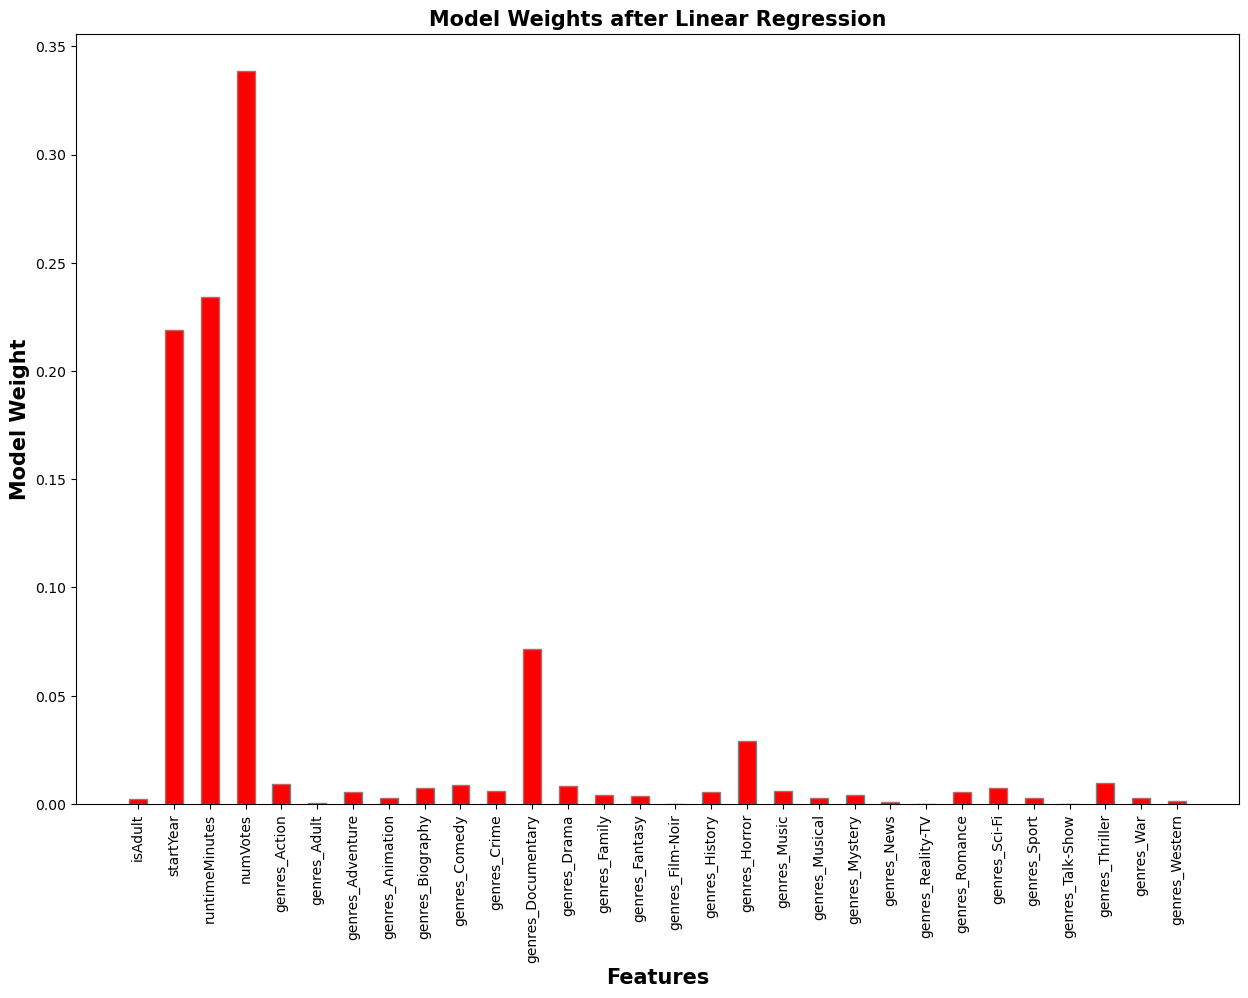

In [24]:
barWidth = 0.50
fig = plt.subplots(figsize =(15, 10))
plt.bar(list(X_dev.columns), rf.feature_importances_, color ='r', width = barWidth,
        edgecolor ='grey', label ='Weight')
plt.title('Model Weights after Linear Regression', fontweight ='bold', fontsize = 15)
plt.xlabel('Features', fontweight ='bold', fontsize = 15, wrap = True)
plt.ylabel('Model Weight', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(X_dev.columns))],
           list(X.columns), rotation ='vertical')
plt.show()

In [25]:
feature_names = X_dev.columns
feature_imps = zip(feature_names, rf.feature_importances_)
feature_imps=sorted(list(feature_imps), key=lambda x: x[1], reverse=True)
feature_imps

[('numVotes', 0.33875770128462107),
 ('runtimeMinutes', 0.23398176622005493),
 ('startYear', 0.2189605748429999),
 ('genres_Documentary', 0.0716314778464636),
 ('genres_Horror', 0.029247746677911766),
 ('genres_Thriller', 0.009564617574342463),
 ('genres_Action', 0.009396589151064434),
 ('genres_Comedy', 0.008608481223800158),
 ('genres_Drama', 0.008145271352588525),
 ('genres_Sci-Fi', 0.007460131558183165),
 ('genres_Biography', 0.007448112975378487),
 ('genres_Music', 0.005914280790478491),
 ('genres_Crime', 0.0058362894925369875),
 ('genres_Romance', 0.005493528131455324),
 ('genres_History', 0.0053512864062039275),
 ('genres_Adventure', 0.005310150457422415),
 ('genres_Family', 0.004059389337615863),
 ('genres_Mystery', 0.003934111262631304),
 ('genres_Fantasy', 0.003741088542010157),
 ('genres_Sport', 0.002960229172157131),
 ('genres_Animation', 0.002924154875988048),
 ('genres_War', 0.0028522261775325137),
 ('genres_Musical', 0.0027089128670526714),
 ('isAdult', 0.002449974635658